### Emma Klemets, 260775167   
All my work, code, output and written answers for **Q2** are in this notebook.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import wmap_camb_example

import corner

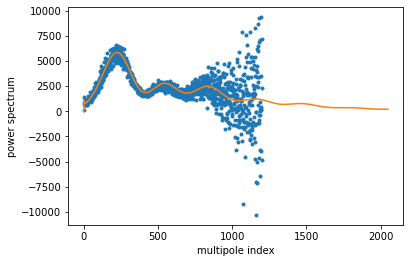

In [5]:
#given code
plt.ion()

#[H_0, w_bh2, w_ch2, tau, A_s, slope]
pars=np.asarray([65,0.02,0.1,0.05,2e-9,0.96])

#[multipole index, measured power spectrum, error, instrument noise part, “cosmic variance” part]
wmap=np.loadtxt('wmap_tt_spectrum_9yr_v5.txt')

plt.clf();
# plt.errorbar(wmap[:,0],wmap[:,1],wmap[:,2],fmt='*', alpha=0.1)
plt.plot(wmap[:,0],wmap[:,1],'.') 

cmb=wmap_camb_example.get_spectrum(pars)

plt.plot(cmb) #what really is the x values here then?
plt.xlabel("multipole index")
plt.ylabel("power spectrum")

plt.show()

### 2) 
Using Gaussian, uncorrelated errors, what do you get for χ2 for the model in my example script, where the Hubble constant H_0 = 65 km/s, the physical baryon density $ω_bh^2=0.02$, the cold dark matter density $ω_ch^2 = 0.1$ the optical depth $τ = 0.05$, the primordial amplitude of fluctuations is $A_s = 2 × 10^{−9}$, and the slope of the primordial power law is 0.96 (where 1 would be scale-invariant). The baryon/dark matter densities are defined relative to the critical density required to close the universe, scaled by h^2 where $h ≡ H_0/100 ∼ 0.7$.   
Note that the universe is assumed to be spatially flat (for reasons too long to justify here), so the dark matter density relative to critical for these parameters would be $1 − (ω_bh^2 + ω_ch^2)/h^2 =71.6%$ for the model assumed here. (You may want to play around plotting different models as you change parameters to get a sense for how the CMB depends on them.)   
If everything has gone well, you should get something around 1588 (please give a few extra digits) for χ2 for this model.

In [6]:
#calculates chi^2
def chisq(data,pars):
    x=data[0]
    y=data[1]
    noise=data[2]
    
    #enforce prior - set chi to inf if tau is negative to not get these terms
    if pars[3] < 0:
        chisq = np.inf
    else:
        model=cmbfun(x,pars)[2:]

        chisq=np.sum( (y-model)**2/noise**2)
    
    return chisq

def cmbfun(x,pars):
    #call the cmb function with the current parameters
    y = wmap_camb_example.get_spectrum(pars, len(x))
    return y

In [7]:
#chi: sum( (data - fitted)^2/sigma^2 )

#assuming Gaussian, uncorrelated errors --> N is diagonal and sigma_i is simplly the error on each value

#[H_0, w_bh2, w_ch2, tau, A_s, slope]
pars=np.asarray([65,0.02,0.1,0.05,2e-9,0.96])
cmb=wmap_camb_example.get_spectrum(pars)

chiSq = 0

for i in range(0, len(wmap)):
    
    chiSq += (wmap[i,1]-cmb[i+2])**2 / wmap[i,2]**2
#     print((wmap[i,1]-cmb[i])**2 / wmap[i,2]**2)

print("Chi squared is: {}".format(chiSq)) #hmm not that close

#my actual chisquared function is slightly different???
print(chisq([wmap[:,0], wmap[:,1], wmap[:,2]], pars))

Chi squared is: 1588.2376532931519
1588.4366720631901


### 3) 
Keeping the optical depth fixed at 0.05, write a Newton’s method/LevenbergMarquardt minimizer and use it to find the best-fit values for the other parameters, and their errors. What are they?   
If you were to keep the same set of parameter but now float τ, what would you expect the new errors to be? Note that CAMB does not provide derivatives with respect to parameters, so you’ll have to come up with something for that. *Please also provide a plot showing why we should believe your derivative estimates.*

In [43]:
variables = ['H_0', 'w_b h^2', 'w_c h^2', 'tau', 'A_s', 'slope']

#numerical derivative, taking a couple points
def derive_long(x, params, i, Min, Max, steps):

    fitP = params[i]

    var = np.linspace(fitP - Min , fitP + Max, steps)

    smaller = np.where(var < fitP)[0][-1]
    bigger = np.where(var > fitP)[0][0]
        
    paramArr = [ np.where(params==fitP, v, params) for v in var]

    #quite slow - this is not going to be efficent
    y = np.array([wmap_camb_example.get_spectrum(p, 1820)[2:] for p in paramArr])
    
    slope = [(y[bigger,int(j)] - y[smaller,int(j)]) / (var[bigger] - var[smaller]) for j in x]
    
    chiArr = []
    for run in y:
        chiSq = 0

        for i in range(0, len(wmap)):
            chiSq += (wmap[i,1]-run[i+2])**2 / wmap[i,2]**2
            
        chiArr.append(chiSq)

    return [slope, y, var, chiArr]


#numerical derivative using just two points
def derive_short(x, params, i, stepSize):

    fitP = params[i]

    x1 = fitP + stepSize
    x2 = fitP - stepSize
       
    paramArr1 = np.where(params==fitP, x1, params)
    paramArr2 = np.where(params==fitP, x2, params)

    y1 = wmap_camb_example.get_spectrum(paramArr1, 1820)[2:]
    y2 = wmap_camb_example.get_spectrum(paramArr2, 1820)[2:]
    
    slope = [(y1[int(j)] - y2[int(j)]) / (x1 - x2) for j in x]

    return [slope]

#### Checking derivatives

In [56]:
pars_guess=np.asarray([65, 0.02, 0.1, 0.05, 2e-9, 0.96])

x=wmap[:,0]

# results = derive_long(x, pars_guess, 0, 10, 10, 8)
# results = derive(x, pars_guess, 1, 0.001, 0.001, 8)
# results = derive(x, pars_guess, 2, 0.05, 0.05, 8)
# results = derive(x, pars_guess, 3, 0.005, 0.005, 8)
# results = derive(x, pars_guess, 4 ,1e-9, 1e-9, 8)
results = derive(x, pars_guess, 5, 0.5, 0.5, 8)

slope = results[0]
y = results[1]
var = results[2]
chi_vals = results[3]

In [57]:
x=wmap[:,0]

# results_short = derive_short(x, pars_guess, 0, 4)[0]
# results_short = derive_short(x, pars_guess, 1, 0.001/2.0)[0]
# results_short = derive_short(x, pars_guess, 2, 0.05/2.0)[0]
# results_short = derive_short(x, pars_guess, 3, 0.005)[0]
# results_short = derive_short(x, pars_guess, 4, 1e-9/2.0)[0]
results_short = derive_short(x, pars_guess, 5, 0.5/2.0)[0]


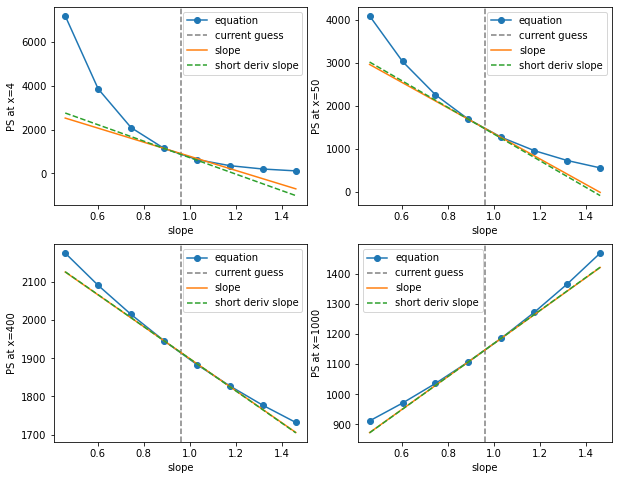

In [58]:
p = 5

fig, ax = plt.subplots(2, 2, figsize=(10,8))

axs = ax.flatten()
current = pars_guess[p]

for i, x in enumerate([4, 50, 400, 1000]):

    #mx + b
    b = y[3,x] - slope[x]*var[3]
    b_short = y[3,x] - results_short[x]*var[3]

    #dep on x value
    axs[i].plot(var, y[:,x], label='equation', marker="o")
    axs[i].set_xlabel(variables[p])
    axs[i].set_ylabel("PS at x={}".format(x))
    axs[i].axvline(current, color='grey', ls="--", label="current guess")
    axs[i].plot(var, slope[x]*var + b, label='slope')
    axs[i].plot(var, results_short[x]*var + b_short, label='short deriv slope', ls="--")

    axs[i].legend()

plt.show()

In [69]:
#really want derive of X^2 - so calculate this
#should look like a line -> want data points to move linearily so we have safetly ignore cross terms


def lookAtChi(pars_guess, step, title):
    x=wmap[:,0]

    fig, ax = plt.subplots(2, 3, figsize=(12,9))
    axs = ax.flatten()


    for i in range(0, 6):
    #     print(variables[i])
        # results = derive(x, pars_guess, 0, 10, 10, 8)
        results = derive(x, pars_guess, i, step[i], step[i], 8)

        chi_vals = results[3]

        var = results[2]
        chi_vals = results[3]

        axs[i].plot(var, chi_vals)
        axs[i].axvline(pars_guess[i], color='grey', ls="--", label="current guess")
        axs[i].set_ylabel("$\chi^2$")
        axs[i].set_xlabel(variables[i])

    fig.suptitle(title)
    plt.show()
       

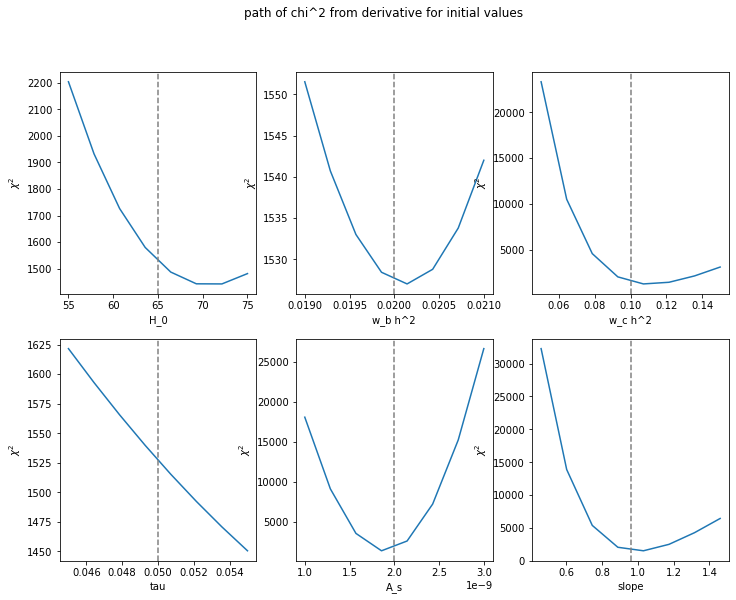

In [59]:
pars_guess=np.asarray([65, 0.02, 0.1, 0.05, 2e-9, 0.96])
step = [10, .001, 0.05, 0.005, 1e-9, 0.5]

title = "path of chi^2 from derivative for initial values"
lookAtChi(pars_guess, step, title)

Looking at the derivatives of each paramter (with the others fixed) seen in "derivative_checks.pdf", these numerical derivatives seem well behaved for the given step size and can be used safely. I also looked at the $\chi^2$, it looks fairly smooth for these step sizes. I can already see that tau behaves differently than the others, where for the fixed other values, most of the parameters have a minimum for $\chi^2$ quite close by, but tau does not.

#### Newton's Method time

In [9]:
#function and derivatives
def f_cmb(x, params, fitVals='all', fixVals=[]):
    
    derivs=np.zeros([len(x),len(params)])
        
    if fitVals=='5':
        params = np.insert(params, 2, fixVals)
       
    elif fitVals=='tau':
        params = np.insert(fixVals, 3, params)
    
    y = wmap_camb_example.get_spectrum(params, lmax=len(x))[:-2]
    
    if fitVals=='5':
        derivs[:,0]=derive_short(x, params, 0, 4)[0]
        derivs[:,1]=derive_short(x, params, 1, 0.001/2.0)[0]
        derivs[:,2]=derive_short(x, params, 2, 0.05/2.0)[0]
        derivs[:,3]=derive_short(x, params, 4, 1e-9/2.0)[0]
        derivs[:,4]=derive_short(x, params, 5, 0.5/2.0)[0]
       
    elif fitVals=='tau':
        if params[3] < 0:
            derivs[:,0] = -10000*np.ones(len(x))
            print("n")
        else:
            derivs[:,0]=derive_short(x, params, 3, 0.005)[0]
    else:
    
        derivs[:,0]=derive_short(x, params, 0, 4)[0]
        derivs[:,1]=derive_short(x, params, 1, 0.001/2.0)[0]
        derivs[:,2]=derive_short(x, params, 2, 0.05/2.0)[0]

        if params[3] < 0:
            derivs[:,3] = 10000*np.ones(len(x))
            print("n")
        else:
            derivs[:,3]=derive_short(x, params, 3, 0.005)[0]

        derivs[:,4]=derive_short(x, params, 4, 1e-9/2.0)[0]
        derivs[:,5]=derive_short(x, params, 5, 0.5/2.0)[0]
    
    return y,derivs

In [66]:
#set up for the fitting
sig=wmap[:,2]
y=wmap[:,1]
# N=np.eye(len(x))*sig**2
Ninv=np.eye(len(y))/sig**2

#could add in check for how chi^2 is changing and end loop if it's not improving much

# newton's method with Levenberg-Marquardt
def NM_withLM(x, guesses, steps, fitVals='all', fixVals=[]):
    pars_guess=np.asarray(guesses)

    pars_cur=pars_guess.copy()

    pars_savedArr = []
    Lambda = 0
    prev_chi = np.inf

    for iter in range(steps):
        y_pred,derivs=f_cmb(x,pars_cur, fitVals=fitVals,fixVals=fixVals)
        resid=y-y_pred #data minus current model

        if fitVals=='tau':
            cov = []
        else:
            cov = np.dot(derivs.transpose(),Ninv)
            cov = np.dot(cov,derivs)
            cov = np.linalg.inv(cov)

        rhs=derivs.T@(Ninv@resid)
        lhs=derivs.T@Ninv@derivs
        
        if fitVals=='tau':
            cov = []
        else:
#             cov = np.dot(derivs.transpose(),Ninv)
#             cov = np.dot(cov,derivs)
            cov = np.linalg.inv(lhs)

        #rescale this on diagonal
        for i in range(len(lhs[0])):
            lhs[i][i] = (1+Lambda)*lhs[i][i]

        step=np.linalg.inv(lhs)@rhs

        if fitVals=='5':
            chi_pars = np.insert(pars_cur+step, 2, fixVals)
        elif fitVals=='tau':
            chi_pars = np.insert(fixVals, 3, pars_cur+step)
        else:
            chi_pars = pars_cur + step
            
        chi = chisq([x, y, sig], chi_pars)

        #chiSq improves, take step
        if chi < prev_chi:
            pars_cur = pars_cur+step
            pars_savedArr.append(pars_cur) #save values for corvarience matrix
            Lambda = Lambda / np.sqrt(2) #make lambda step smaller
            print('iteration ',iter,' has step ',step)
            
            if np.abs(chi - prev_chi) < 0.5:
                print("Small chi square change")

        #chiSq doesn't improves
        else:
            if Lambda == 0:
                Lambda = 2
            else:
                Lambda = 2*Lambda
    #             pars_cur = pars_cur+step
            print('iteration ',iter, 'has step ',step, 'and increase lambda to ',Lambda)

        prev_chi = chi #save new chisquared for next step

        print("chisq: ", chi)

    par_errs=np.sqrt(np.diag(np.linalg.inv(lhs)))
    
    return [pars_cur, par_errs, pars_savedArr, cov]

In [67]:
pars_guess=np.asarray([65, 0.02, 0.1, 2e-9, 0.96])
x=wmap[:,0]

#fitting the 5 parameters without tau
fit5results = NM_withLM(x, pars_guess, 8, fitVals='5', fixVals=[0.05])
print("Got values {}, with errors {}".format(fit5results[0], fit5results[1]))

pars_fitted=np.insert(fit5results[0], 2, 0.05)

cov_5 = fit5results[3]
#do the chi^2 slope graphs again here

iteration  0  has step  [ 3.56898189e+01 -4.84323847e-03 -2.07662342e-02 -7.42398037e-10
 -9.23726936e-03]
chisq:  3860.4446769717806
iteration  1  has step  [-3.67977850e+00  9.38978722e-03  8.40111790e-03  4.24915353e-10
  7.21641240e-02]
chisq:  1813.6423437888432
iteration  2 has step  [-1.80192123e+01 -4.45970142e-03  2.57512657e-02  1.95248591e-10
 -5.83902679e-02] and increase lambda to  2
chisq:  5205.3037264697205
iteration  3  has step  [ 3.26406790e+00 -1.25371014e-03  1.42571739e-03 -1.02530281e-11
  6.25319400e-03]
chisq:  1531.8672303948865
iteration  4  has step  [ 2.70254845e+00 -7.53498174e-04  1.09501968e-03 -4.23040417e-12
  1.83143884e-03]
chisq:  1444.178188586538
iteration  5  has step  [ 1.96975908e+00 -3.30703144e-04  8.56774796e-04 -6.08296363e-13
 -4.71244371e-04]
chisq:  1425.809221398766
iteration  6  has step  [ 1.25148956e+00 -6.29552825e-05  7.42663065e-04  1.52580395e-12
 -8.60257522e-04]
Small chi square change
chisq:  1425.6824819300045
iteration  7 ha

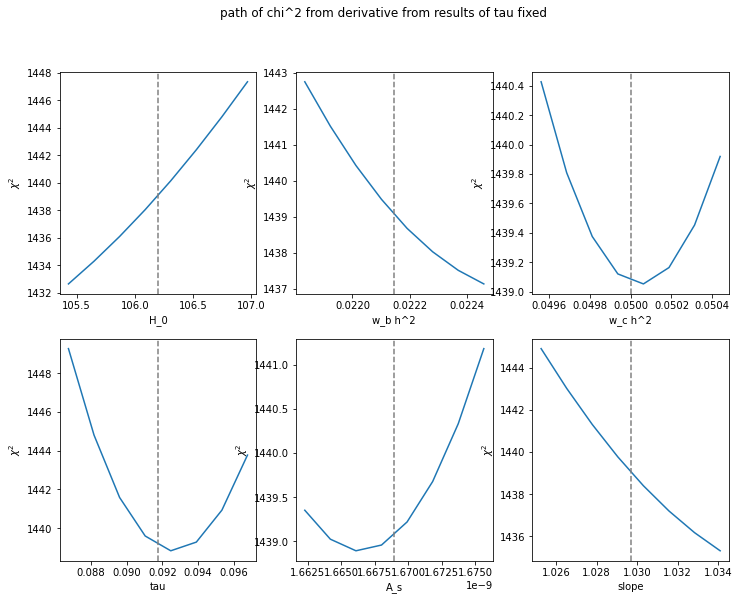

In [70]:
pars_guess=np.asarray([1.06197905e+02, 2.21456820e-02, 9.17550587e-02, 0.05, 1.66895139e-09, 1.02967999e+00])
step = [7.68922753e-01, 3.11636548e-04, 4.38586606e-04, 0.005,6.68287160e-12, 4.41842348e-03]

title = "path of chi^2 from derivative from results of tau fixed"
lookAtChi(pars_fitted, step, title)

In [ ]:
#tau is strongly correlated to other params, think about what these correlation would do

#fitting just for tau while holding other values fixed
tau_guess = [0.05]
fitTau_results = NM_withLM(x, tau_guess, 30, fitVals='tau', fixVals=fit5results[0])
# fitTau_results = NM_withLM(x, tau_guess, 30, fitVals='tau', fixVals=pars_guess)


print("Got values {}, with errors {}".format(fitTau_results[0], fitTau_results[1]))

# 2663.6184681416153
# Got values [2.81711625e-08], with errors [1.81131343e-05]
#exactly same thing with slope if tau < 0 as +/-10000, i feel like it shouldn't do this

In [66]:
#fitting all 6 parameters
print("start with", pars_fitted)

fitAll_results = NM_withLM(x, pars_fitted, 20, fitVals='all')
print("Got values {}, with errors {}".format(fitAll_results[0], fitAll_results[1]))

#save corvariance matrix for sample for MCMC
cov = fitAll_results[3]

start with [1.06197905e+02 2.21456820e-02 5.00000000e-02 9.17550587e-02
 1.66895139e-09 1.02967999e+00]
iteration  0  has step  [-8.23409858e+00  3.44794498e-03  1.40889025e-02  6.05908966e-01
  2.24540427e-09  5.32097498e-02]
chisq:  10982.176863164368
iteration  1  has step  [-1.72191235e+01  2.58281786e-03  3.14027781e-02 -3.50271446e-01
  4.11857211e-10  7.63189252e-02]
chisq:  3454.7749013053526
iteration  2 has step  [-1.96413804e+01 -8.36537346e-03  2.84813780e-02 -2.95349177e-01
 -3.09951611e-09 -2.52139458e-01] and increase lambda to  2
chisq:  13547.646783550552
iteration  3  has step  [ 2.56300829e+00 -1.37564604e-04  5.10962690e-03  1.49930637e-02
 -1.21660703e-10  1.18767312e-02]
chisq:  1656.5210968659908
iteration  4  has step  [ 1.35413430e+00  1.84083827e-04  2.70741769e-03  8.85971941e-03
 -6.71745491e-11 -3.27813048e-03]
chisq:  1331.05189941994
iteration  5  has step  [ 5.96655952e-01  1.58175358e-04  8.13849295e-04  4.85923739e-03
 -3.37749852e-11 -1.02119684e-02]


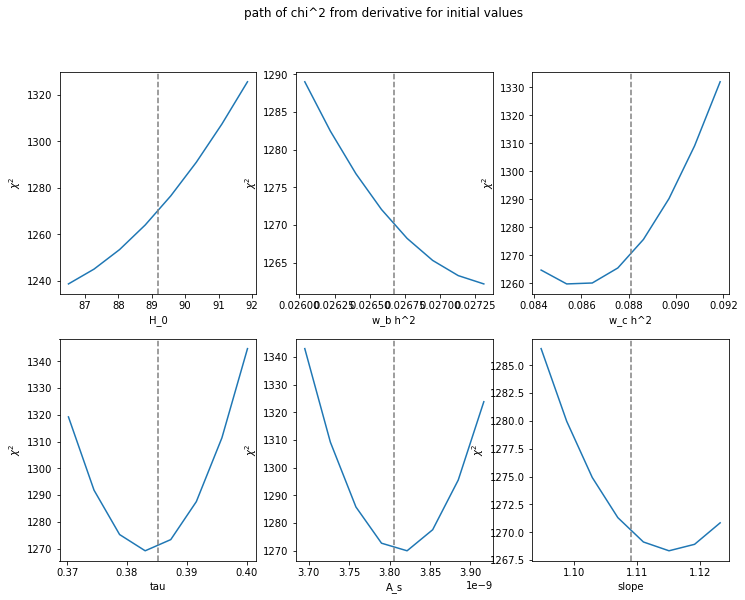

In [23]:
# cov

pars_guess=np.asarray([8.91853726e+01, 2.66745567e-02, 8.80833909e-02, 3.85185078e-01, 3.80581496e-09, 1.10901041e+00])
step = [2.67988840e+00, 6.36602154e-04, 3.77729627e-03, 1.49724000e-02, 1.10882123e-10, 1.41553442e-02]

title = "path of chi^2 from derivative from results of all float"
lookAtChi(pars_guess, step, title)

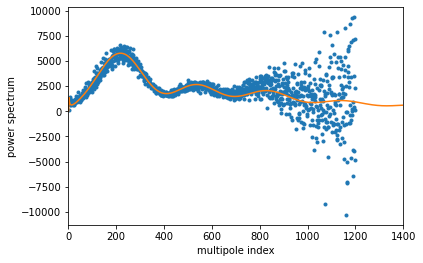

In [19]:
#plot to see how the 5 fitted parameters look

def plotResults(pars_fitted)
    #[H_0, w_bh2, w_ch2, tau, A_s, slope]
    pars_fitted=np.insert(pars_cur, 2, 0.05)

    #[multipole index, measured power spectrum, error, instrument noise part, “cosmic variance” part]

    plt.plot(wmap[:,0],wmap[:,1],'.') 

    cmb=wmap_camb_example.get_spectrum(pars_fitted)

    plt.plot(cmb) #what really is the x values here then?
    plt.xlabel("multipole index")
    plt.ylabel("power spectrum")
    plt.xlim(0, 1400)

    plt.show()

*If you were to keep the same set of parameter but now float τ, what would you expect the new errors to be?*

I expect the error to be much worse from just changing tau, we can't really compare errors, but just looking at $\chi ^2$, we can see below that this gets much worst values when only fitting tau, propably because there is no good way to apply the prior we know where tau must be non-negative.

-> more degrees of freedom